In [149]:
import torch
import torch.nn as nn
import firedrake as fd
import firedrake_adjoint  # noqa
import numpy as np
import ufl
from torchfire import fd_to_torch
import fdm
from fecr import evaluate_primal, evaluate_pullback
from torch.autograd import Variable
import torchviz
import matplotlib.pyplot as plt


class neural_net(torch.nn.Module):

    def __init__(self):
        super(neural_net, self).__init__()
        self.linear1 = nn.Linear(32, 32)
        self.activation1 = nn.ReLU()
        self.linear2 = torch.nn.Linear(32, 32)
        #torch.nn.init.normal_(self.linear2.weight, mean=1.0, std=1.0)
        self.activation2 = nn.Sigmoid()
        self.float()

    def forward(self, x):
        x = torch.flatten(x)
        x = self.linear1(x)
        x = self.activation1(x)
        x = self.linear2(x)
        x = self.activation2(x)
        return x

def a_function(kappa):
    V = fd.FunctionSpace(mesh, "P", 1)
    x = fd.SpatialCoordinate(mesh)
    F = fd.Function(V)
    
    F.interpolate( fd.div( 1.0 / (1.0 + x[0]**2 + x[1]**2) * fd.grad(fd.sin(x[0] * fd.pi) * fd.sin( x[1] * fd.pi))  ))
    
    u = fd.Function(V)
    v = fd.TestFunction(V)
    bcs = [fd.DirichletBC(V, F, (1,))]

    a = (fd.inner( kappa * fd.grad(u), fd.grad(v))  - F * v  )* fd.dx

    fd.solve( a  == 0, u, bcs=bcs)
    return u

def u_solution(kappa):
    x = fd.SpatialCoordinate(mesh)
    F = fd.Function(V)
    F.interpolate(fd.sin(x[0] * fd.pi) * fd.sin( x[1] * fd.pi))
    return F

def kappa_solution(kappa):
    x = fd.SpatialCoordinate(mesh)
    F = fd.Function(V_kappa)
    F.interpolate( 1.0 / (1.0 + x[0]**2 + x[1]**2) )
    return F

In [150]:
N = 8
mesh = fd.UnitSquareMesh(N, 2)
V = fd.FunctionSpace(mesh, "P", 1)
V_kappa = fd.FunctionSpace(mesh, "DG", 0)
x = fd.SpatialCoordinate(mesh)
print(V.dim())
print(V_kappa.dim())


27
32


In [151]:
u_sol_templates = (fd.Function(V), )
u_sol_input = (torch.ones(V.dim(), requires_grad=False),)
u_sol = fd_to_torch(u_solution, u_sol_templates, "bob_u_sol")
u_sol_ = u_sol.apply(*u_sol_input)
u_sol_

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 3.8268e-01, 0.0000e+00, 0.0000e+00,
        7.0711e-01, 4.6865e-17, 0.0000e+00, 9.2388e-01, 8.6596e-17, 0.0000e+00,
        1.0000e+00, 1.1314e-16, 0.0000e+00, 9.2388e-01, 1.2246e-16, 0.0000e+00,
        7.0711e-01, 1.1314e-16, 0.0000e+00, 3.8268e-01, 8.6596e-17, 0.0000e+00,
        1.2246e-16, 4.6865e-17, 1.4998e-32], dtype=torch.float64)

In [152]:
kappa_true_templates = (fd.Function(V_kappa), )
kappa_true_input = (torch.ones(V_kappa.dim(), requires_grad=False),)
kappa_true = fd_to_torch(kappa_solution, kappa_true_templates, "bob_kappa_sol")
kappa_true_ = kappa_true.apply(*kappa_true_input)
kappa_true_

tensor([0.9713, 0.8944, 0.9474, 0.6915, 0.8662, 0.5878, 0.8986, 0.6792, 0.8182,
        0.5754, 0.8324, 0.6538, 0.7569, 0.5538, 0.7569, 0.6180, 0.6890, 0.5251,
        0.6792, 0.5754, 0.6200, 0.4915, 0.6044, 0.5294, 0.5538, 0.4553, 0.5353,
        0.4828, 0.4927, 0.4186, 0.4377, 0.3827], dtype=torch.float64)

In [153]:
templates = (fd.Function(V_kappa),)
inputs = (torch.ones(V_kappa.dim(), requires_grad=True),)
a = fd_to_torch(a_function, templates, "bob_a")
a_ = a.apply


In [ ]:
error_L2 = nn.MSELoss()
learning_rate = 0.01
kappa_nn = neural_net() #neural_net(N, 68, N)
optimizer = torch.optim.SGD(kappa_nn.parameters(), lr=learning_rate)
losses = []

for epoch in range(1000):
    print(f"Epoch:{epoch}")
    kappa = kappa_nn(*inputs)
    u = a_(kappa)

    loss = error_L2(u, u_sol_)
    grad_x, = torch.autograd.grad(loss, inputs, create_graph=True)
    torchviz.make_dot((grad_x, inputs[0] , loss), params={"grad_x": grad_x, "x": inputs[0], "out": loss}).render("attached",format="png")
    losses.append(loss)
    print(f"Loss:{loss}")

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

plt.plot([loss.detach() for loss in losses][1:])
plt.savefig('losses.png')
plt.close()


Epoch:0
Loss:8.369089563864863
Epoch:1
Loss:4.792631905704941
Epoch:2
Loss:3.043301983535357
Epoch:3
Loss:2.74938633131648
Epoch:4
Loss:2.6282214570233258
Epoch:5
Loss:2.5631272415420217
Epoch:6
Loss:2.5227663754461327
Epoch:7
Loss:2.495292050465602
Epoch:8
Loss:2.475300178261744
Epoch:9
Loss:2.4600045483308333
Epoch:10
Loss:2.447835891428493
Epoch:11
Loss:2.4378459923453484
Epoch:12
Loss:2.4294230160349466
Epoch:13
Loss:2.4221422554081538
Epoch:14
Loss:2.415678895387603
Epoch:15
Loss:2.409745731298623
Epoch:16
Loss:2.4040301445899455
Epoch:17
Loss:2.3980857181216186
Epoch:18
Loss:2.3910547550848174
Epoch:19
Loss:2.380694067424505
Epoch:20
Loss:2.358613635759819
Epoch:21
Loss:2.319859358057972
Epoch:22
Loss:2018913.5034267937
Epoch:23
Loss:7.2530284788175
Epoch:24
Loss:6.780745439743585
Epoch:25
Loss:6.411703152241914
Epoch:26
Loss:6.1130816922896765
Epoch:27
Loss:5.865081676224501
Epoch:28
Loss:5.654932058840747
Epoch:29
Loss:5.473967448590376
Epoch:30
Loss:5.3160688461856225
Epoch:31

Loss:2.7399397058760866
Epoch:249
Loss:2.7386367906934446
Epoch:250
Loss:2.737343410918557
Epoch:251
Loss:2.736059443633537
Epoch:252
Loss:2.7347849538471363
Epoch:253
Loss:2.73351980004945
Epoch:254
Loss:2.7322637720915313
Epoch:255
Loss:2.731016744755103
Epoch:256
Loss:2.729778920224647
Epoch:257
Loss:2.728549910783722
Epoch:258
Loss:2.7273296331058625
Epoch:259
Loss:2.726117972096619
Epoch:260
Loss:2.7249149756306403
Epoch:261
Loss:2.7237203918360993
Epoch:262
Loss:2.7225341678295822
Epoch:263
Loss:2.7213564924514153
Epoch:264
Loss:2.7201868667935196
Epoch:265
Loss:2.719025434154637
Epoch:266
Loss:2.7178719175965664
Epoch:267
Loss:2.7167264088769376
Epoch:268
Loss:2.7155888957540126
Epoch:269
Loss:2.7144591026346054
Epoch:270
Loss:2.7133369696966523
Epoch:271
Loss:2.7122223555609914
Epoch:272
Loss:2.71111553198591
Epoch:273
Loss:2.7100160628152348
Epoch:274
Loss:2.7089239155691334
Epoch:275
Loss:2.707839103408572
Epoch:276
Loss:2.706761436949129
Epoch:277
Loss:2.7056911682789035
Epo

Loss:2.57047407365701
Epoch:494
Loss:2.5701041959021853
Epoch:495
Loss:2.5697355866138842
Epoch:496
Loss:2.569368436143234
Epoch:497
Loss:2.5690025198886284
Epoch:498
Loss:2.568638022392485
Epoch:499
Loss:2.568274899618442
Epoch:500
Loss:2.567912948536023
Epoch:501
Loss:2.567552453147413
Epoch:502
Loss:2.567193231425079
Epoch:503
Loss:2.5668353719387476
Epoch:504
Loss:2.5664787123692028
Epoch:505
Loss:2.5661235209160274
Epoch:506
Loss:2.565769452478049
Epoch:507
Loss:2.5654167939795998
Epoch:508
Loss:2.5650653224159234
Epoch:509
Loss:2.5647150678380757
Epoch:510
Loss:2.5643661361486267
Epoch:511
Loss:2.5640185110520144
Epoch:512
Loss:2.563672135817575
Epoch:513
Loss:2.5633268403959426
Epoch:514
Loss:2.56298294688394
Epoch:515
Loss:2.5626401382634585
Epoch:516
Loss:2.5622986322789436
Epoch:517
Loss:2.5619583829609307
Epoch:518
Loss:2.561619219653265
Epoch:519
Loss:2.561281328797997
Epoch:520
Loss:2.5609445777783413
Epoch:521
Loss:2.5606090458408084
Epoch:522
Loss:2.5602747198301845
Epoc

Epoch:738
Loss:2.5078843632701666
Epoch:739
Loss:2.5077078755275037
Epoch:740
Loss:2.507531815467248
Epoch:741
Loss:2.5073561588387157
Epoch:742
Loss:2.507180989731754
Epoch:743
Loss:2.507006175812557
Epoch:744
Loss:2.5068319176371006
Epoch:745
Loss:2.5066580020428866
Epoch:746
Loss:2.5064844595112072
Epoch:747
Loss:2.5063113858907844
Epoch:748
Loss:2.50613874823683
Epoch:749
Loss:2.505966567406142
Epoch:750
Loss:2.505794733357515
Epoch:751
Loss:2.50562345593676
Epoch:752
Loss:2.505452539488299
Epoch:753
Loss:2.5052819000739635
Epoch:754
Loss:2.505111840957184
Epoch:755
Loss:2.5049421626146606
Epoch:756
Loss:2.5047729378161594
Epoch:757
Loss:2.504603994887361
Epoch:758
Loss:2.504435521606203
Epoch:759
Loss:2.5042674771012483
Epoch:760
Loss:2.5040998591751893
Epoch:761
Loss:2.5039326221429605
Epoch:762
Loss:2.503765723213171
Epoch:763
Loss:2.5035993013794204
Epoch:764
Loss:2.50343333329379
Epoch:765
Loss:2.5032675747816038
Epoch:766
Loss:2.5031024312129238
Epoch:767
Loss:2.5029374870982

Loss:2.474550032358281
Epoch:985
Loss:2.4744459929164626
Epoch:986
Loss:2.474342214622636
Epoch:987
Loss:2.4742386163693286
Epoch:988
Loss:2.474135174717473
Epoch:989
Loss:2.4740319578559666
Epoch:990
Loss:2.473928903973674
Epoch:991
Loss:2.473826120845393
Epoch:992
Loss:2.4737235202979075
Epoch:993
Loss:2.4736210138383004
Epoch:994
Loss:2.4735187030868824
Epoch:995


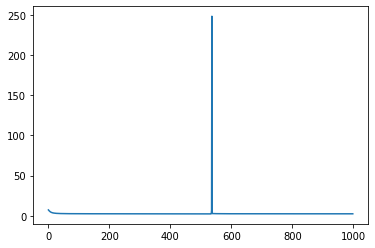

In [155]:
plt.plot([loss.detach() for loss in losses][1:])
#plt.savefig('losses.png')
#plt.close()

In [137]:
print("kappa_nn: \n",kappa)

kappa_nn: 
 tensor([0.9976, 0.9978, 0.9969, 0.9978, 0.9972, 0.9973, 0.9956, 0.9967, 0.9951,
        0.9966, 0.9921, 0.9955, 0.9869, 0.9936, 0.9822, 0.9928, 0.9762, 0.9881,
        0.9480, 0.9695, 0.9575, 0.9714, 0.7907, 0.8163, 0.6778, 0.9069, 0.4691,
        0.2969, 0.6895, 0.8078, 0.4895, 0.6812], grad_fn=<SigmoidBackward0>)


In [138]:
print("kappa_true: \n",kappa_true_)

kappa_true: 
 tensor([0.9713, 0.8944, 0.9474, 0.6915, 0.8662, 0.5878, 0.8986, 0.6792, 0.8182,
        0.5754, 0.8324, 0.6538, 0.7569, 0.5538, 0.7569, 0.6180, 0.6890, 0.5251,
        0.6792, 0.5754, 0.6200, 0.4915, 0.6044, 0.5294, 0.5538, 0.4553, 0.5353,
        0.4828, 0.4927, 0.4186, 0.4377, 0.3827], dtype=torch.float64)


In [160]:
kappa.detach().numpy() - kappa_true_.numpy()

array([ 0.02808223,  0.10477807,  0.05172058,  0.30778807,  0.13279055,
        0.41137151,  0.10002469,  0.31961245,  0.18039327,  0.42341093,
        0.16553293,  0.34459205,  0.23987025,  0.44423148,  0.23804677,
        0.37839463,  0.30495068,  0.47178576,  0.30685926,  0.41809056,
        0.35458028,  0.50043692,  0.32946914,  0.42069033,  0.09021297,
        0.51554371,  0.10271615, -0.18699974,  0.50726664,  0.4872035 ,
        0.56230645,  0.61727563])

In [139]:
print("u_pred: \n",u)

u_pred: 
 tensor([-0.0000, -0.0000, -0.4271, -0.5063, -0.8278,  0.0000, -0.9590, -0.4221,
        -1.1663, -1.3185, -0.7938, -1.4217, -1.5674, -1.0914, -1.5906, -1.7118,
        -1.3046, -1.6850, -1.7768, -1.4378, -1.7286, -1.7885, -1.5088, -1.7422,
        -1.7759, -1.5426, -1.5536], dtype=torch.float64,
       grad_fn=<bob_aBackward>)


In [140]:
print("u_true: \n",u_sol_)

u_true: 
 tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 3.8268e-01, 0.0000e+00, 0.0000e+00,
        7.0711e-01, 4.6865e-17, 0.0000e+00, 9.2388e-01, 8.6596e-17, 0.0000e+00,
        1.0000e+00, 1.1314e-16, 0.0000e+00, 9.2388e-01, 1.2246e-16, 0.0000e+00,
        7.0711e-01, 1.1314e-16, 0.0000e+00, 3.8268e-01, 8.6596e-17, 0.0000e+00,
        1.2246e-16, 4.6865e-17, 1.4998e-32], dtype=torch.float64)


In [ ]:
- div( KAPPA * grad(U) ) = f


KAPPA_nn(mesh) 

